# Stock analysis

## Import

Libraries

In [1]:
from utils.init import *

from utils.analyse_price import *
from utils.analyse_fundementals import *
from utils.data import *
from utils.params import *

In [2]:
TICKER = 'AAPL'
COUNTRY = 'US'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices_dict = {}

## Get data

Run data

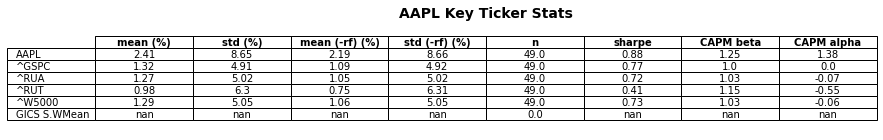

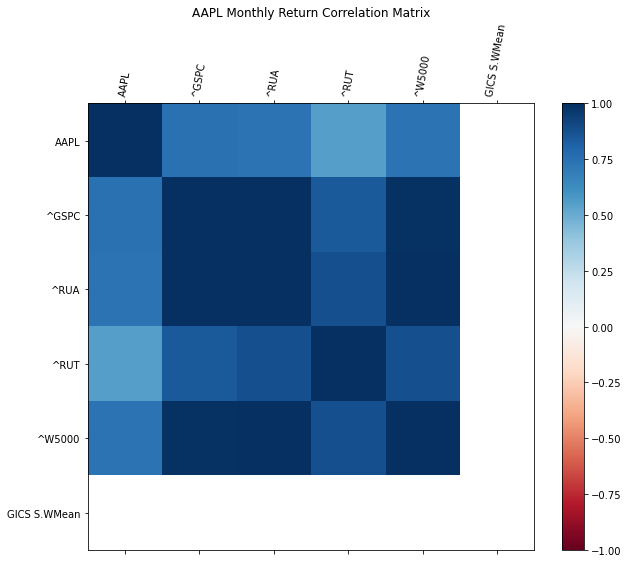

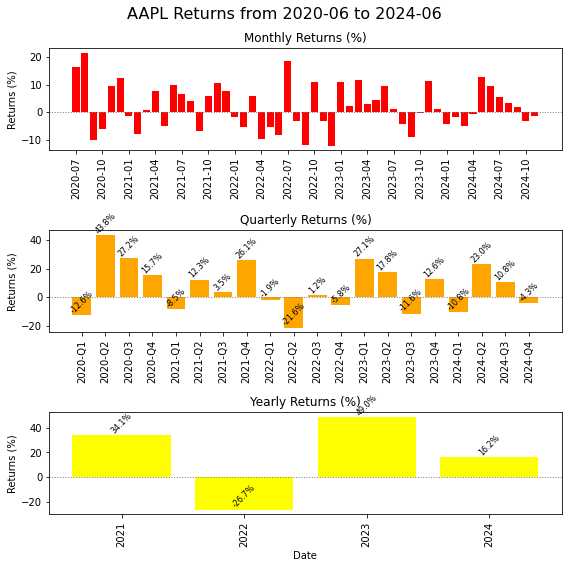

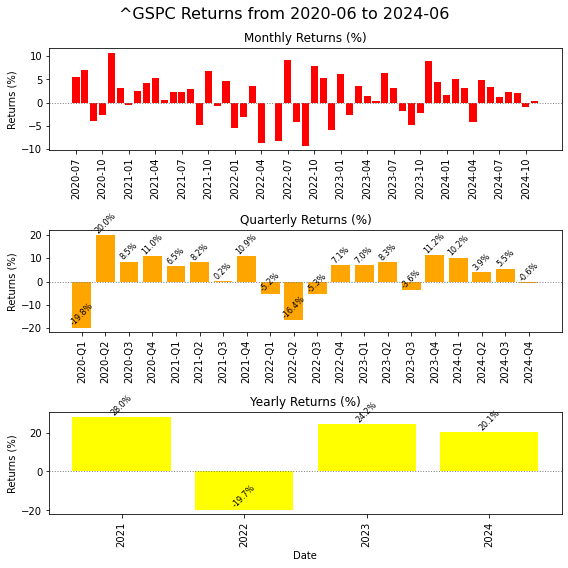

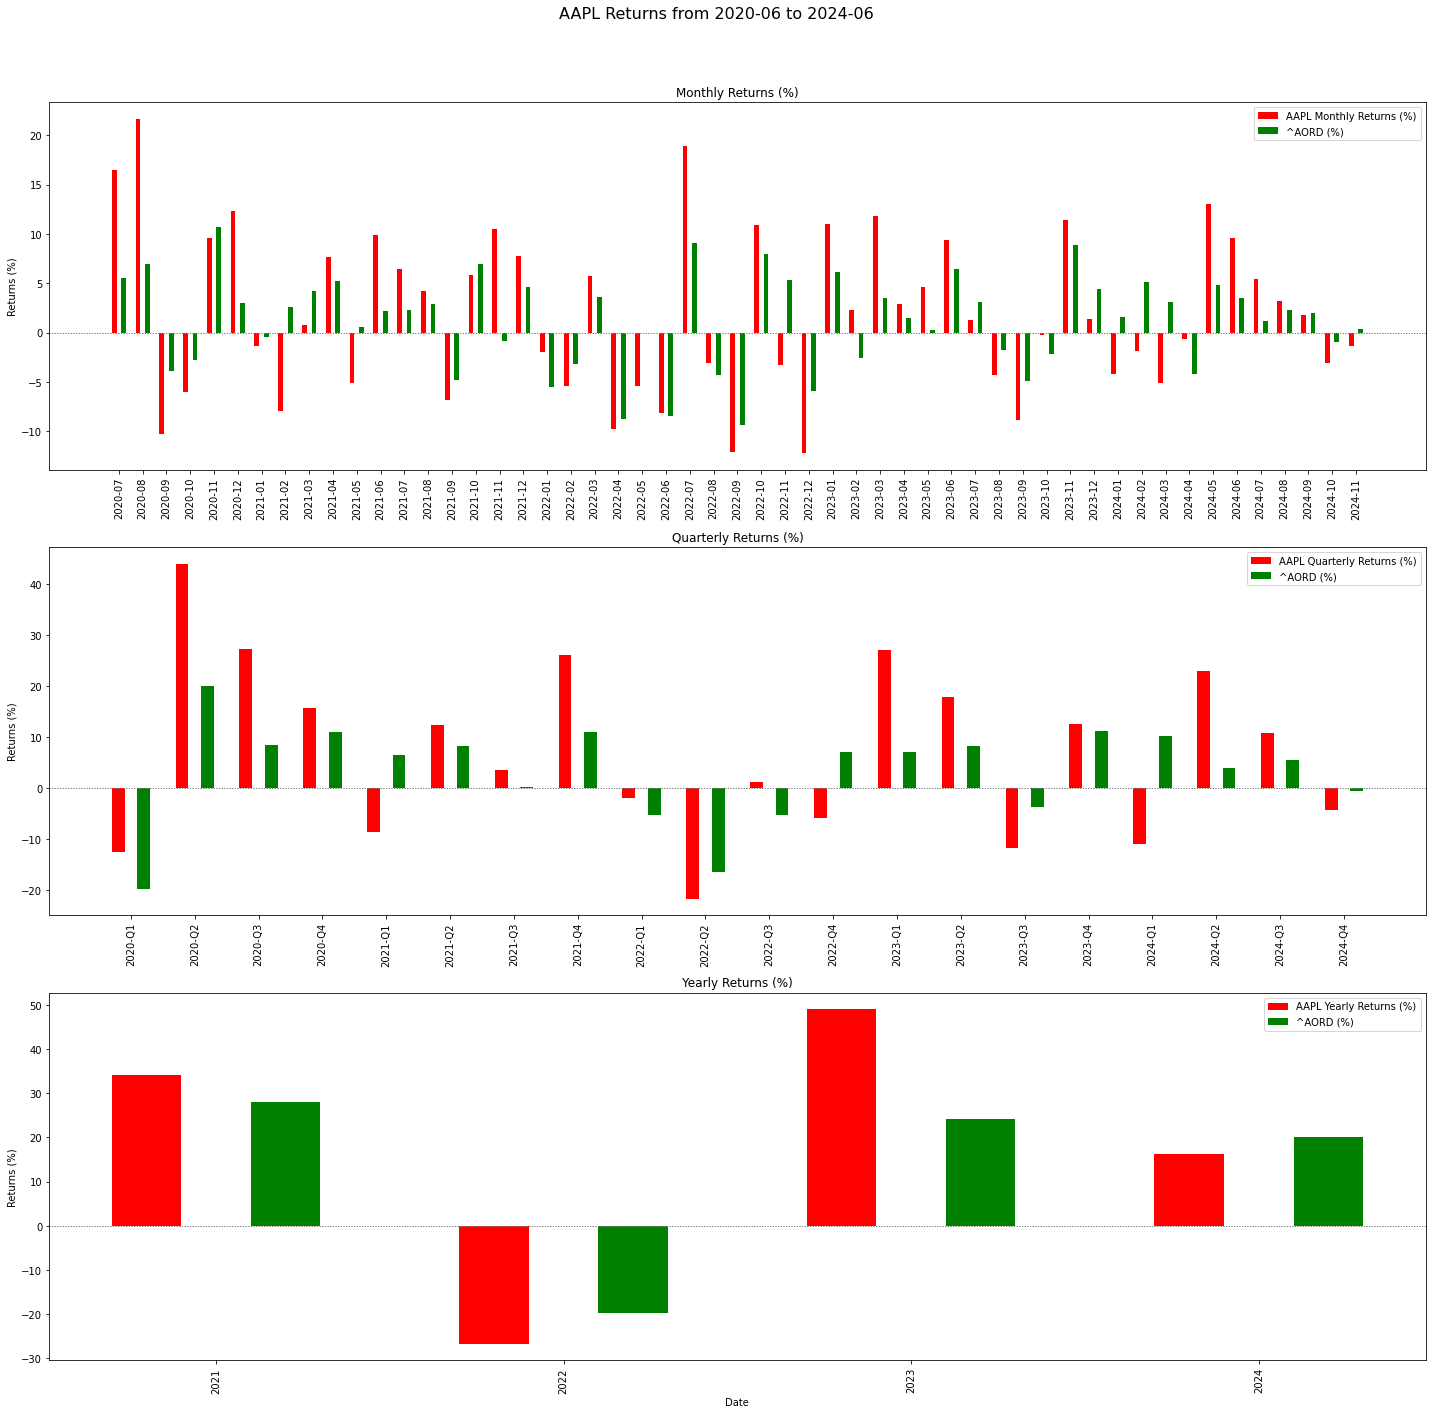

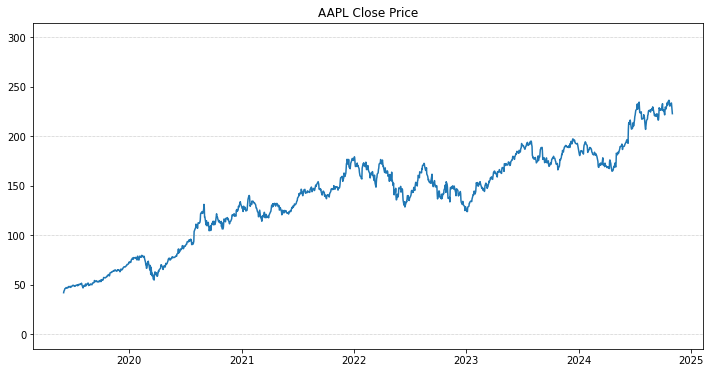

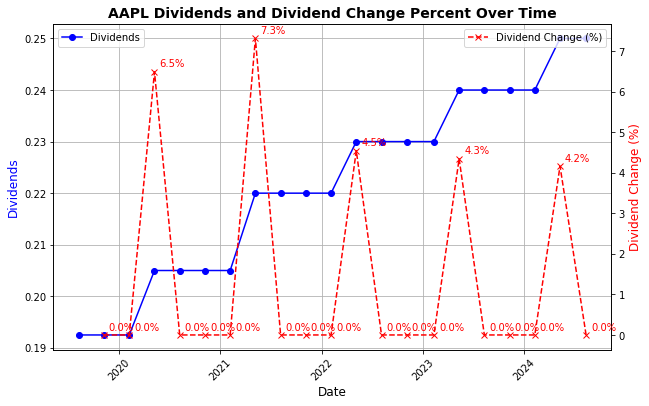

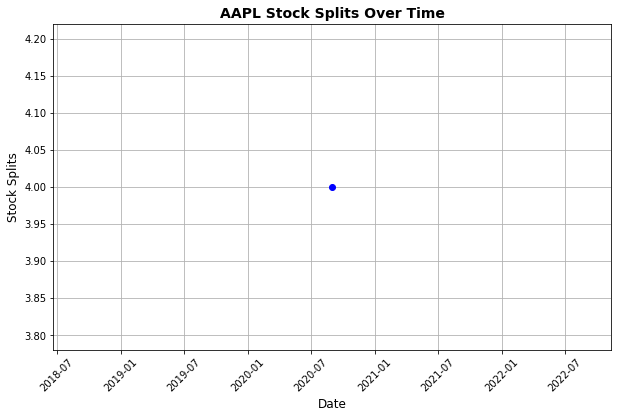

In [3]:
# read in data
index_tickers_list = get_index_tickers_list(COUNTRY)
interest_rate_df_dict = get_interest_rate(COUNTRY)

comparable_tickers = {'type': {}, 'list': []}
if COUNTRY == 'AU':
    asx_companies_directory_df = get_asx_companies_directory()
    asx_gics_df = get_asx_gics()

    # get same gics tickers

    AU_top_list_dict = get_top_ASX_companies_list(asx_companies_directory_df)
    ASX_ticker_gics_dict = get_ASX_ticker_gics(TICKER, asx_gics_df)
    same_gics_ASX_tickers_dict = get_same_gics_ASX_tickers(asx_gics_df,
                                                           ASX_ticker_gics_dict, AU_top_list_dict)
    comparable_ASX_tickers_dict = get_comparable_ASX_tickers(
        TICKER, same_gics_ASX_tickers_dict)

    print(comparable_ASX_tickers_dict['type'])

    same_industry_ASX_tickers_mcap_df = get_same_gics_ASX_MCap_weights(TICKER,
                                                                       asx_companies_directory_df, comparable_ASX_tickers_dict)

    # market value and weight
    same_industry_tickers_mcap_df = get_same_industry_tickers_mcap(
        same_industry_ASX_tickers_mcap_df)
    display(same_industry_tickers_mcap_df)

    ticker_mv_df = get_AU_ticker_mv_df(asx_companies_directory_df, TICKER)
    display(ticker_mv_df)

    ticker_proportion_of_market = get_AU_ticker_proportion_of_market(
        ticker_mv_df, same_industry_tickers_mcap_df)
    print(round(ticker_proportion_of_market, 2))

    plot_gics_mcap_weights(TICKER, same_industry_tickers_mcap_df)

    same_gics_industry_weight_dict = get_same_AU_gics_industry_weight_dict(
        same_industry_tickers_mcap_df)

# get historic prices
analysis_needed_ticker_list = get_analysis_needed_ticker_list(
    TICKER, index_tickers_list, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
historical_prices_dict = get_historical_prices_for_interested_list(
    analysis_needed_ticker_list, index_tickers_list, historical_prices_dict, COUNTRY)

# get historical returns
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['monthly'], 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['quarterly'], 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices_dict.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, interest_rate_df_dict['annualy'], 'Y')

# get GICS industry weighted returns
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'M', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'Q', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, analysis_needed_ticker_list, same_gics_industry_weight_dict if COUNTRY == 'AU' else None,
    index_tickers_list, 'Y', comparable_tickers=comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers)

# get stats based on returns
stats_dict = {}
for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_monthly_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter, COUNTRY)
stats_df = pd.DataFrame(stats_dict).T
stats_df = get_stats_df(TICKER, stats_df, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers,
                        index_tickers_list, same_industry_tickers_mcap_df if COUNTRY == 'AU' else None)
plot_key_ticker_stats_table(
    stats_df, TICKER, comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers, index_tickers_list)

# correlation chart
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)
plot_correlation(correlation_df, ticker=TICKER)

# plot returns
# interested ticker
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

if COUNTRY == 'AU' and len(comparable_ASX_tickers_dict['list']) > 0:
    plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                    'quarterly_returns_df_dict': quarterly_returns_df_dict,
                    'yearly_returns_df_dict': yearly_returns_df_dict,
                    'ticker': 'GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else 'GICS S.WMean',
                    'first_end_of_quarter': first_end_of_quarter,
                    'last_end_of_quarter': last_end_of_quarter,
                    'underlying_ticker': TICKER})

plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD' if COUNTRY == 'AU' else '^GSPC',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_ASX_tickers_dict if COUNTRY == 'AU' else comparable_tickers, 'country': COUNTRY}
                         )

# price movement
plot_close_price_with_dollar_lines(TICKER, historical_prices_dict)

# dividends
historical_dividends = get_historical_dividends(
    TICKER, historical_prices_dict, COUNTRY)
plot_dividends(TICKER, historical_dividends, historical_prices_dict, COUNTRY)

# historical splits
historical_splits = get_historical_splits(
    TICKER, historical_prices_dict, COUNTRY)
plot_splits_over_time(TICKER, historical_prices_dict, COUNTRY)

# fundementals

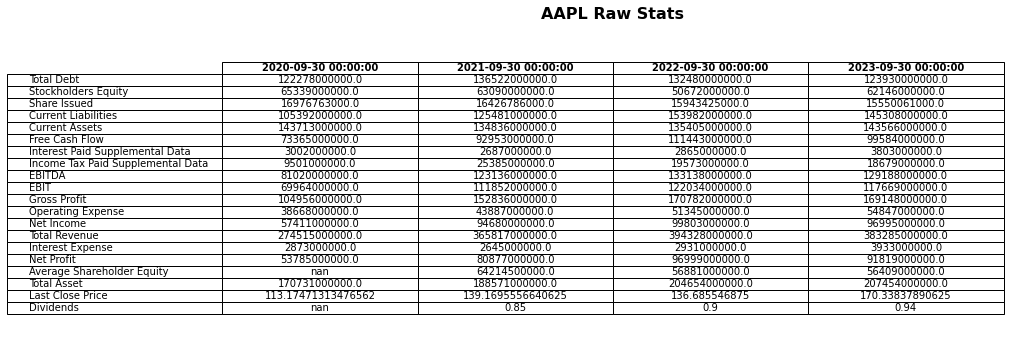

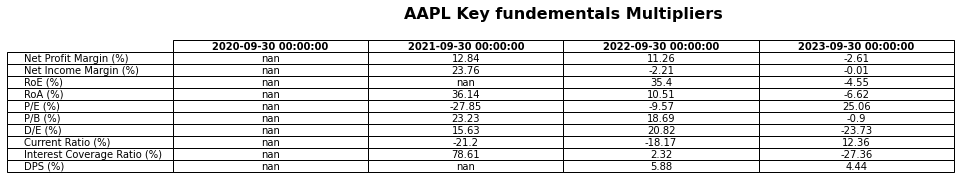

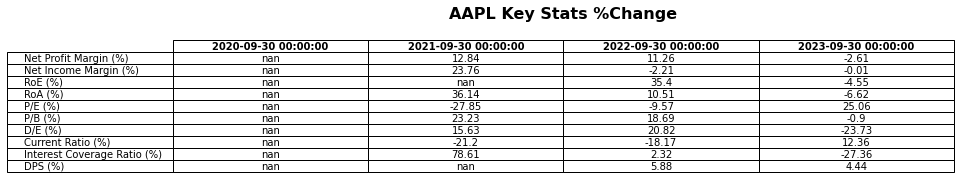

Column Net Profit Margin not found for GICS: 'Net Profit Margin'


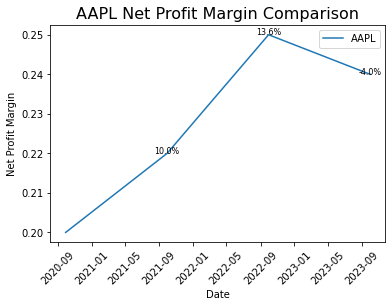

Column Net Income Margin not found for GICS: 'Net Income Margin'


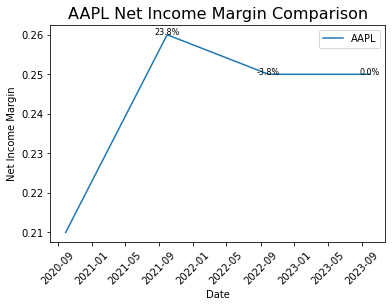

Column RoE not found for GICS: 'RoE'


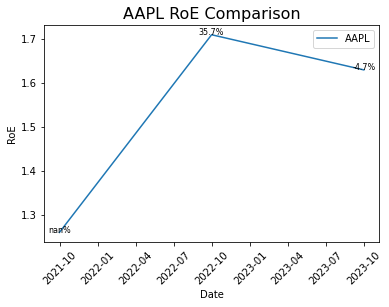

Column RoA not found for GICS: 'RoA'


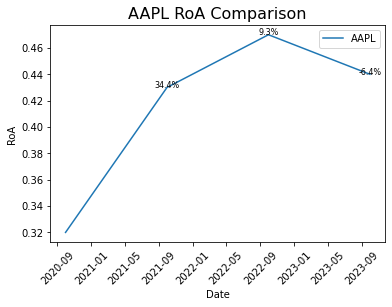

Column P/E not found for GICS: 'P/E'


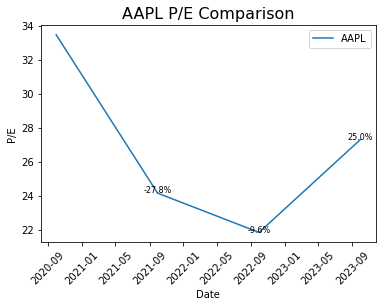

Column P/B not found for GICS: 'P/B'


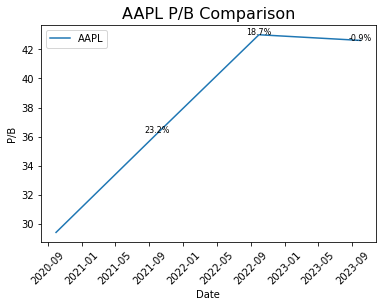

Column D/E not found for GICS: 'D/E'


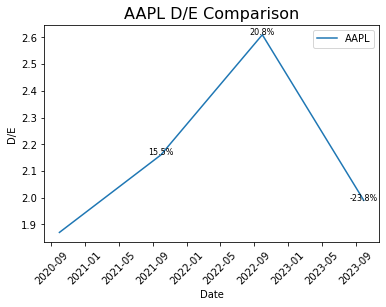

Column Current Ratio not found for GICS: 'Current Ratio'


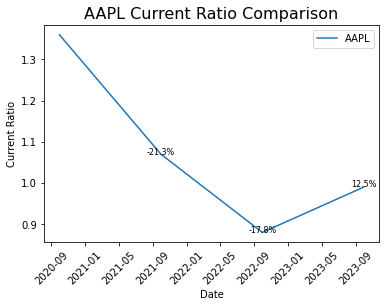

Column Interest Coverage Ratio not found for GICS: 'Interest Coverage Ratio'


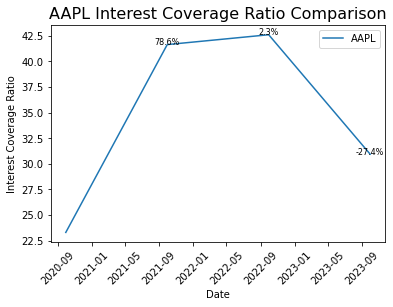

Column DPS not found for GICS: 'DPS'


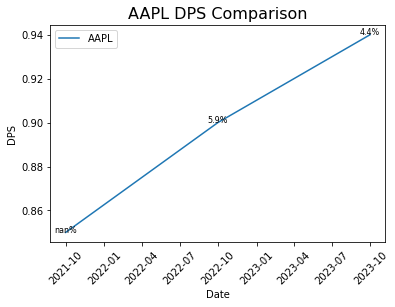

In [8]:
got_fundementals = False

if not (COUNTRY == 'AU' and ASX_ticker_gics_dict['Sector'] == 'Unknown' and ASX_ticker_gics_dict['Industry'] == 'Unknown'):

    got_fundementals = True

    # get fundementals for ticker of interest
    interested_ticker_raw_fundementals_stats, interested_ticker_key_interested_fundementals_stats, interested_ticker_key_interested_fundementals_stats_pct_change, object = get_fundementals_dfs(
        first_end_of_quarter, historical_prices_dict, TICKER, COUNTRY)
    # create tables for fundementals for ticker of interest
    plot_raw_fundementals_stats_table(
        interested_ticker_raw_fundementals_stats, TICKER)
    plot_key_fundementals_multipliers_table(
        interested_ticker_key_interested_fundementals_stats_pct_change, TICKER)
    plot_key_fundementals_multipliers_pct_change_table(
        interested_ticker_key_interested_fundementals_stats_pct_change, TICKER)

    # get fundementals for comparable tickers
    if COUNTRY == 'AU':

        raw_fundementals_stats_dict = dict()
        object_dict = dict()

        for ticker in comparable_ASX_tickers_dict['list']:
            ticker = ticker.split('.')[0]
            print('\n', ticker)
            raw_stats, key_interested_stats, key_interested_stats_pct_change, object = get_fundementals_dfs(
                first_end_of_quarter, historical_prices_dict, ticker, COUNTRY)

            raw_fundementals_stats_dict[ticker] = raw_stats
            object_dict[ticker] = object

        # interpolate fundementals
        interpolated_fundementals_stats_dict = {}
        for key in raw_fundementals_stats_dict.keys():
            interpolated_fundementals_stats = interpolate_fundementals_stats(
                raw_fundementals_stats_dict, key)
            interpolated_fundementals_stats_dict[key] = interpolated_fundementals_stats
        interested_dates = [pd.to_datetime(
            dt.strftime('%Y-%m')) for dt in interested_ticker_key_interested_fundementals_stats_pct_change.index]

        agg_interpolated_fundementals_stats_df_dict = {}
        for key in interpolated_fundementals_stats_dict:
            agg_interpolated_fundementals_stats_df = agg_interpolated_fundementals_stats(
                interpolated_fundementals_stats_dict[key], interested_dates)
            agg_interpolated_fundementals_stats_df_dict[key] = agg_interpolated_fundementals_stats_df

        # get key interested fundemental stats from the interpolated fundementals for comparable tickers
        key_interested_fundementals_stats_dict = {}
        key_interested_fundementals_stats_pct_change_dict = {}

        for key in agg_interpolated_fundementals_stats_df_dict:
            stock_fundementals = process_stock_fundementals(
                agg_interpolated_fundementals_stats_df_dict[key], object_dict[key], first_end_of_quarter, historical_prices_dict, key)

            key_interested_stats = get_key_interested_fundementals_stats(
                stock_fundementals)

            key_interested_stats_pct_change = get_key_interested_fundementals_stat_pct_change(
                key_interested_stats
            )

            key_interested_fundementals_stats_dict[key] = key_interested_stats
            key_interested_fundementals_stats_pct_change_dict[key] = key_interested_stats_pct_change

        # get weighted average
        weighted_GICS_key_interested_fundementals_stats = get_weighted_fundementals(
            key_interested_fundementals_stats_dict, same_gics_industry_weight_dict)

        weighted_GICS_key_interested_fundementals_stats.index = weighted_GICS_key_interested_fundementals_stats.index

        plot_key_fundementals_multipliers_table(
            weighted_GICS_key_interested_fundementals_stats.astype(float).round(2),  f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')

        # get percentage change for key interested fundemental stats for the weighted average of the GICS industry
        weighted_GICS_key_interested_fundementals_stats_pct_change = get_key_interested_fundementals_stat_pct_change(
            weighted_GICS_key_interested_fundementals_stats)
        weighted_GICS_key_interested_fundementals_stats_pct_change.index = interested_ticker_key_interested_fundementals_stats_pct_change.index
        plot_key_fundementals_multipliers_pct_change_table(
            weighted_GICS_key_interested_fundementals_stats_pct_change, f'{TICKER} GICS I.WMean' if 'industry' in comparable_ASX_tickers_dict['type'] else f'{TICKER} GICS S.WMean')
    else:
        weighted_GICS_key_interested_fundementals_stats = pd.DataFrame()

    # plot the comparison of key interested fundementals for the ticker of interest and the weighted average of the GICS industry
    plot_key_fundamentals_multipliers(
        interested_ticker_key_interested_fundementals_stats, weighted_GICS_key_interested_fundementals_stats, TICKER, {})

PDF

In [7]:
pdf = FPDF()

# TITLE
# Add a page
pdf.add_page()
# Set font for the title
pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
title = f"Stock Analysis of Ticker: {TICKER}"
pdf.cell(200, 10, txt=title, ln=True, align='C')

if COUNTRY == 'AU':
    # Comparable Ticker Universe
    # Set font for the content
    pdf.set_font("Arial", 'B', size=12)
    pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
    pdf.set_font("Arial", size=10)
    text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_ASX_tickers_dict['type'] else 'same SECTOR of MCAP$1BN+'}"
    pdf.cell(200, 10, txt=text, ln=True, align='L')

    # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
    ticker_market_cap_billion = round(
        ticker_mv_df.iloc[0]['Market Cap ($bn)'], 2)
    ticker_proportion_of_market = ticker_mv_df['Market Cap ($bn)'].values[0] / \
        same_industry_tickers_mcap_df['Market Cap ($bn)'].sum()
    universe_market_value_billion = round(
        same_industry_tickers_mcap_df['Market Cap ($bn)'].sum(), 2)
    pdf.cell(
        200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')

# KEY STATS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# COMPARATIVE RETURNS PLOTS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# TICKER RETURN CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# SECTOR/INDUSTRY WMEAN RETURNS CHART
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_ASX_tickers_dict['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# ^AORD CHART
pdf.add_page()
pdf.set_font("Arial", 'B', 12)
pdf.cell(
    200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# CLOSE PRICE CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# DIVIDENDS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# key multipliers
if got_fundementals:
    pdf.add_page()
    pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
    pdf.cell(200, 10, txt=f"{TICKER} Key Multipliers", ln=True, align='L')
    pdf.ln(5)  # Line break before adding the image
    pdf.image(
        f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', x=10, y=None, w=125)

    # gics multipliers
    pdf.image(
        f"../outputs/{TICKER} GICS {'I' if 'industry' in comparable_ASX_tickers_dict['type'] else 'S'}.WMean_interested_ticker_key_interested_stats.png", x=10, y=None, w=125
    )

    # key multiplier pct change
    pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
    pdf.cell(
        200, 10, txt=f"{TICKER} Key Multipliers Pct Change", ln=True, align='L')
    pdf.ln(5)
    pdf.image(
        f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', x=10, y=None, w=125)

    # gics multipliers pct change
    pdf.image(
        f"../outputs/{TICKER} GICS {'I' if 'industry' in comparable_ASX_tickers_dict['type'] else 'S'}.WMean_interested_ticker_key_interested_stats_pct_change.png", x=10, y=None, w=125
    )

    # plots of key multipliers
    pdf.add_page()
    images = [
        f'../outputs/{TICKER}_P_B_comparison.png',
        f'../outputs/{TICKER}_P_E_comparison.png',
        f'../outputs/{TICKER}_Net Income Margin_comparison.png',
        f'../outputs/{TICKER}_Net Profit Margin_comparison.png',
        f'../outputs/{TICKER}_ROE_comparison.png',
        f'../outputs/{TICKER}_ROA_comparison.png',
        f'../outputs/{TICKER}_D_E_comparison.png',
        f'../outputs/{TICKER}_Current Ratio_comparison.png',
        f'../outputs/{TICKER}_Interest Coverage Ratio_comparison.png',
        f'../outputs/{TICKER}_DPS_comparison.png'
    ]

    # Set image dimensions and spacing
    width = 60  # Adjust width to make images smaller
    height_spacing = 50  # Adjust vertical space between rows
    images_per_row = 2  # Number of images per row

    # Loop through images, placing them in a grid
    x, y = 10, 10  # Starting coordinates
    for i, image in enumerate(images):
        pdf.image(image, x=x, y=y, w=width)

        # Update x and y positions for next image
        if (i + 1) % images_per_row == 0:  # Move to the next row
            x = 10
            y += height_spacing
        else:
            x += width + 10  # Move to the next column

# APPENDIX
pdf.add_page()  # Add a new page for the appendix
# Set font for the title
pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# APPENDIX TITLE
title = f"Appendix"
pdf.cell(200, 10, txt=title, ln=True, align='C')

# CORRELATION
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# SPLITS
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# INDUSTRY TICKER MCAP TABLE
pdf.add_page()
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_ASX_tickers_dict['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

if got_fundementals:
    pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
    pdf.image(
        f"../outputs/{TICKER}_interested_ticker_raw_stats.png", x=10, y=None, w=100)

# Save the PDF after adding the image
pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

IndexError: single positional indexer is out-of-bounds